In [21]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import gc


## Set parameters and paths

In [22]:
# Define parameters
res = 1
n_hvg = 2000

In [ ]:
# Define the input and output directories
input_dir = 'Input_files'
output_dir = 'Output_Gabritto_2024_DS1_1'

# Create the output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Analysis for DS1_1

### Load data

In [24]:
file = 'DS1_1.h5ad'

studyID=file.split(".")[0]
print(f'Start process {studyID}')
adata=sc.read_h5ad(os.path.join(input_dir,file))
adata

Start process DS1_1


AnnData object with n_obs × n_vars = 42486 × 36412
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'ADNC_colors', 'APOE4 status_color

### Preprocess and clustering

Start process DS1_1
    Before process: number of obs 42486, number of var 36412
    Start QC
    After process: number of obs 42483, number of var 31747
    It is Normalized and Log-Transformed data, no need to run normalization


/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


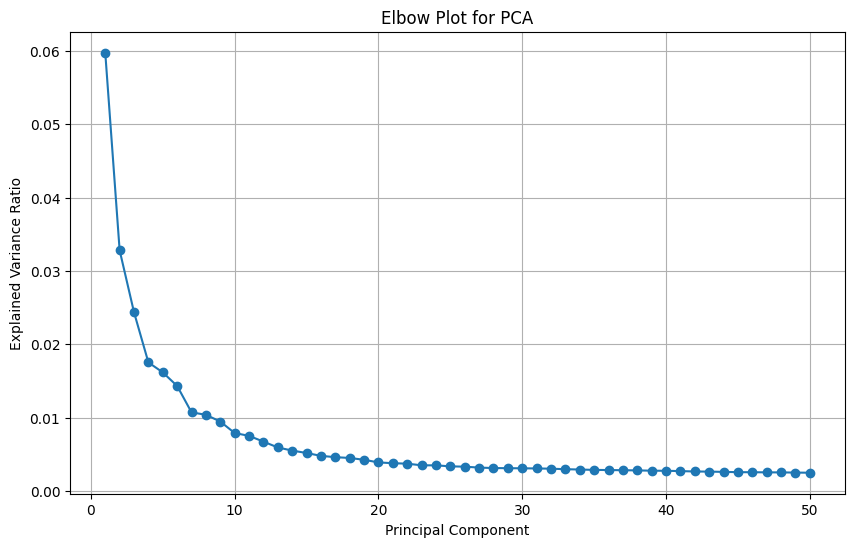

In [25]:
file = 'DS1_1.h5ad'

studyID=file.split(".")[0]
print(f'Start process {studyID}')
adata=sc.read_h5ad(os.path.join(input_dir,file))
print(f'    Before process: number of obs {adata.n_obs}, number of var {adata.n_vars}')

#adata.layers["counts"]=adata.X.copy()
adata.var['GeneID']=adata.var.index
adata.var.set_index('feature_name',inplace=True)
if adata.raw is not None:
    adata.raw.var.set_index('feature_name', inplace=True)
else:
    print("    adata.raw is None, skipping setting index.")
adata.var["mt"]=adata.var_names.str.startswith("MT-")

adata.obs['nCount_RNA'] = adata.obs['Number of UMIs']
adata.obs['nFeature_RNA'] = adata.obs['Genes detected']
del adata.obs['Number of UMIs']
del adata.obs['Genes detected']

# QC
print(f'    Start QC')
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"],inplace=True,log1p=True)
sc.pp.filter_genes(adata,min_cells=3)
adata=adata[adata.obs['nFeature_RNA']>200,:]
adata=adata[adata.obs['pct_counts_mt']<10,:]
adata=adata[adata.obs['nCount_RNA']>400,:]
adata=adata[adata.obs['nCount_RNA']<60000,:]
print(f'    After process: number of obs {adata.n_obs}, number of var {adata.n_vars}')

print(f'    It is Normalized and Log-Transformed data, no need to run normalization')

sc.pp.highly_variable_genes(adata,n_top_genes=n_hvg)
sc.tl.pca(adata)
explained_variance_ratio = adata.uns['pca']['variance_ratio']
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.show()
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)

### Remove non-microglials

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

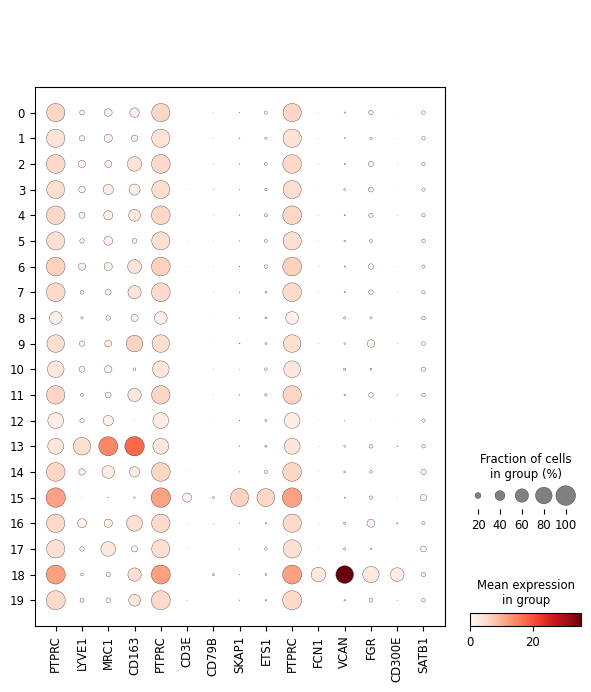

In [26]:
goi=['PTPRC', 'LYVE1', 'MRC1', 'CD163','PTPRC', 'CD3E', 'CD79B', 'SKAP1', 'ETS1','PTPRC', 'FCN1', 'VCAN', 'FGR', 'CD300E','SATB1']
goi_in_adata=[gene for gene in goi if gene in adata.var_names]
sc.pl.dotplot(adata, goi_in_adata, groupby="leiden");

In [27]:
# remove clusters
clusters_to_remove = ['13', '15', '18']
adata = adata[~adata.obs['leiden'].isin(clusters_to_remove), :]
adata

View of AnnData object with n_obs × n_vars = 40754 × 31747
    obs: 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'donor_id', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'PMI', 'Fraction mitochrondrial UMIs', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes'

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


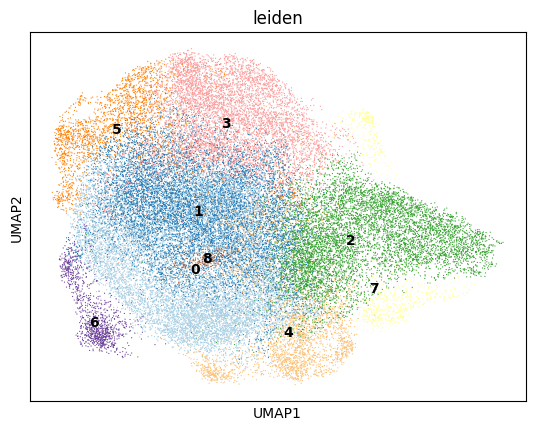

In [28]:
# Reclustering
import scanpy as sc
import matplotlib.pyplot as plt
res = 0.4
sc.pp.highly_variable_genes(adata,n_top_genes=n_hvg)
sc.tl.pca(adata)
sc.pp.neighbors(adata,n_neighbors=10,n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=res,n_iterations=2)
sc.pl.umap(adata, color=['leiden'], palette='Paired',legend_loc='on data', save=f'_{studyID}_microglia_leiden_res{res}.pdf')    

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

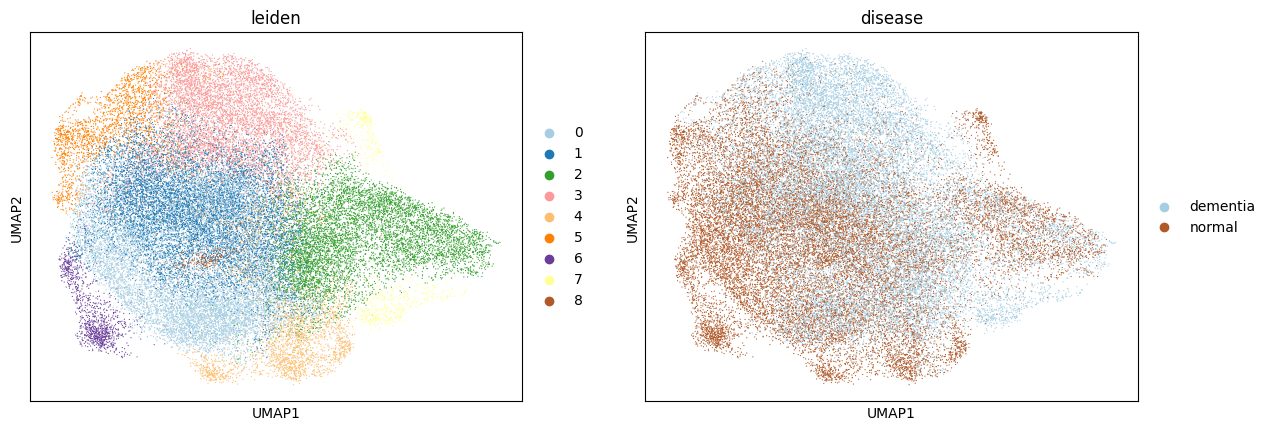

In [29]:
sc.pl.umap(adata, color=['leiden','disease'], palette='Paired', save=f'_{studyID}_microglia_disease_res{res}.pdf')    

### Figure 7E

/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap'

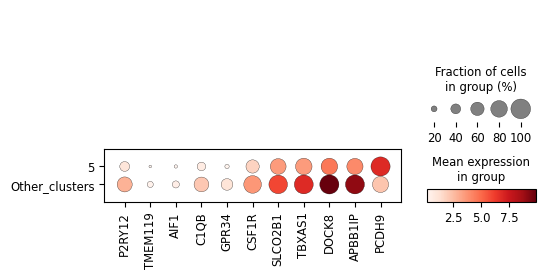

In [38]:
# supplementary figure
goi=['P2RY12','TMEM119','AIF1','C1QB','CX3R1','GPR34','CSF1R','SLCO2B1','TBXAS1','DOCK8','APBB1IP','PCDH9']

# Create a new variable 'cluster2' in adata.obs
adata.obs['cluster2'] = adata.obs['leiden'].apply(lambda x: '5' if x == '5' else 'Other_clusters')
adata.obs['cluster2'] = adata.obs['cluster2'].astype('category')

goi_in_adata=[gene for gene in goi if gene in adata.var_names]
sc.pl.dotplot(adata, goi_in_adata, groupby="cluster2",save=f'{studyID}_microglia_goi_res{res}_check_microgliaMarker.pdf')

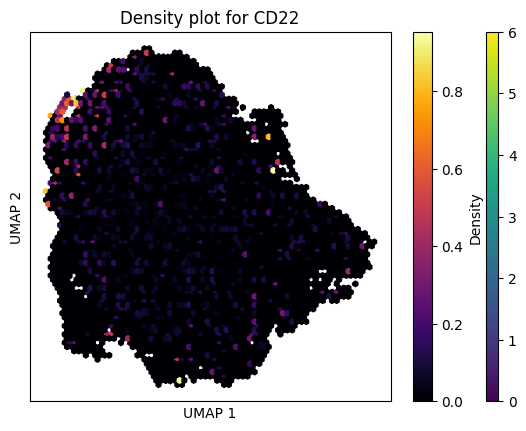

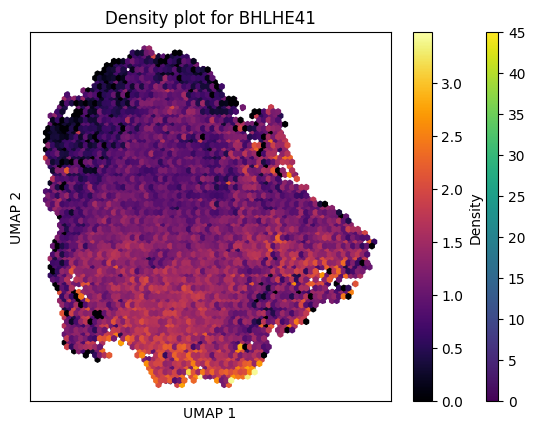

In [20]:
# Importing necessary libraries
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Define the markers you are interested in
markers = ["CD22",'BHLHE41']

# Loop over each marker to create a density plot on UMAP
for marker in markers:
    # Create a UMAP scatter plot colored by marker expression
    sc.pl.umap(adata, color=marker, show=False, cmap='viridis', legend_loc=None,s=20)
    
    # Overlay density (this step is similar to Nebulosa, but done manually)
    ax = plt.gca()  # Get current axis
    
    # Extract UMAP coordinates
    x = adata.obsm['X_umap'][:, 0]  # UMAP 1 coordinates
    y = adata.obsm['X_umap'][:, 1]  # UMAP 2 coordinates
    
    # Extract expression levels of the marker
    expression = adata[:, marker].X.toarray().flatten()
    
   # Create a 2D histogram / density plot
    hexbin_plot = ax.hexbin(x, y, C=expression, gridsize=70, cmap='inferno', reduce_C_function=np.mean, mincnt=1)

    # Set axis labels and title
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(f'Density plot for {marker}')

    # Add the colorbar with the mappable hexbin plot
    plt.colorbar(hexbin_plot, label='Density')
    
    # Save or show the figure
    plt.savefig(f'figures/umap_density_{studyID}_{marker}_within_macrolia.pdf')
    plt.show()

### Identify marker gene

    Start to identify marker gene DS1_1


/Users/yelin.zhao/opt/anaconda3/envs/py3_9_R4_30/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


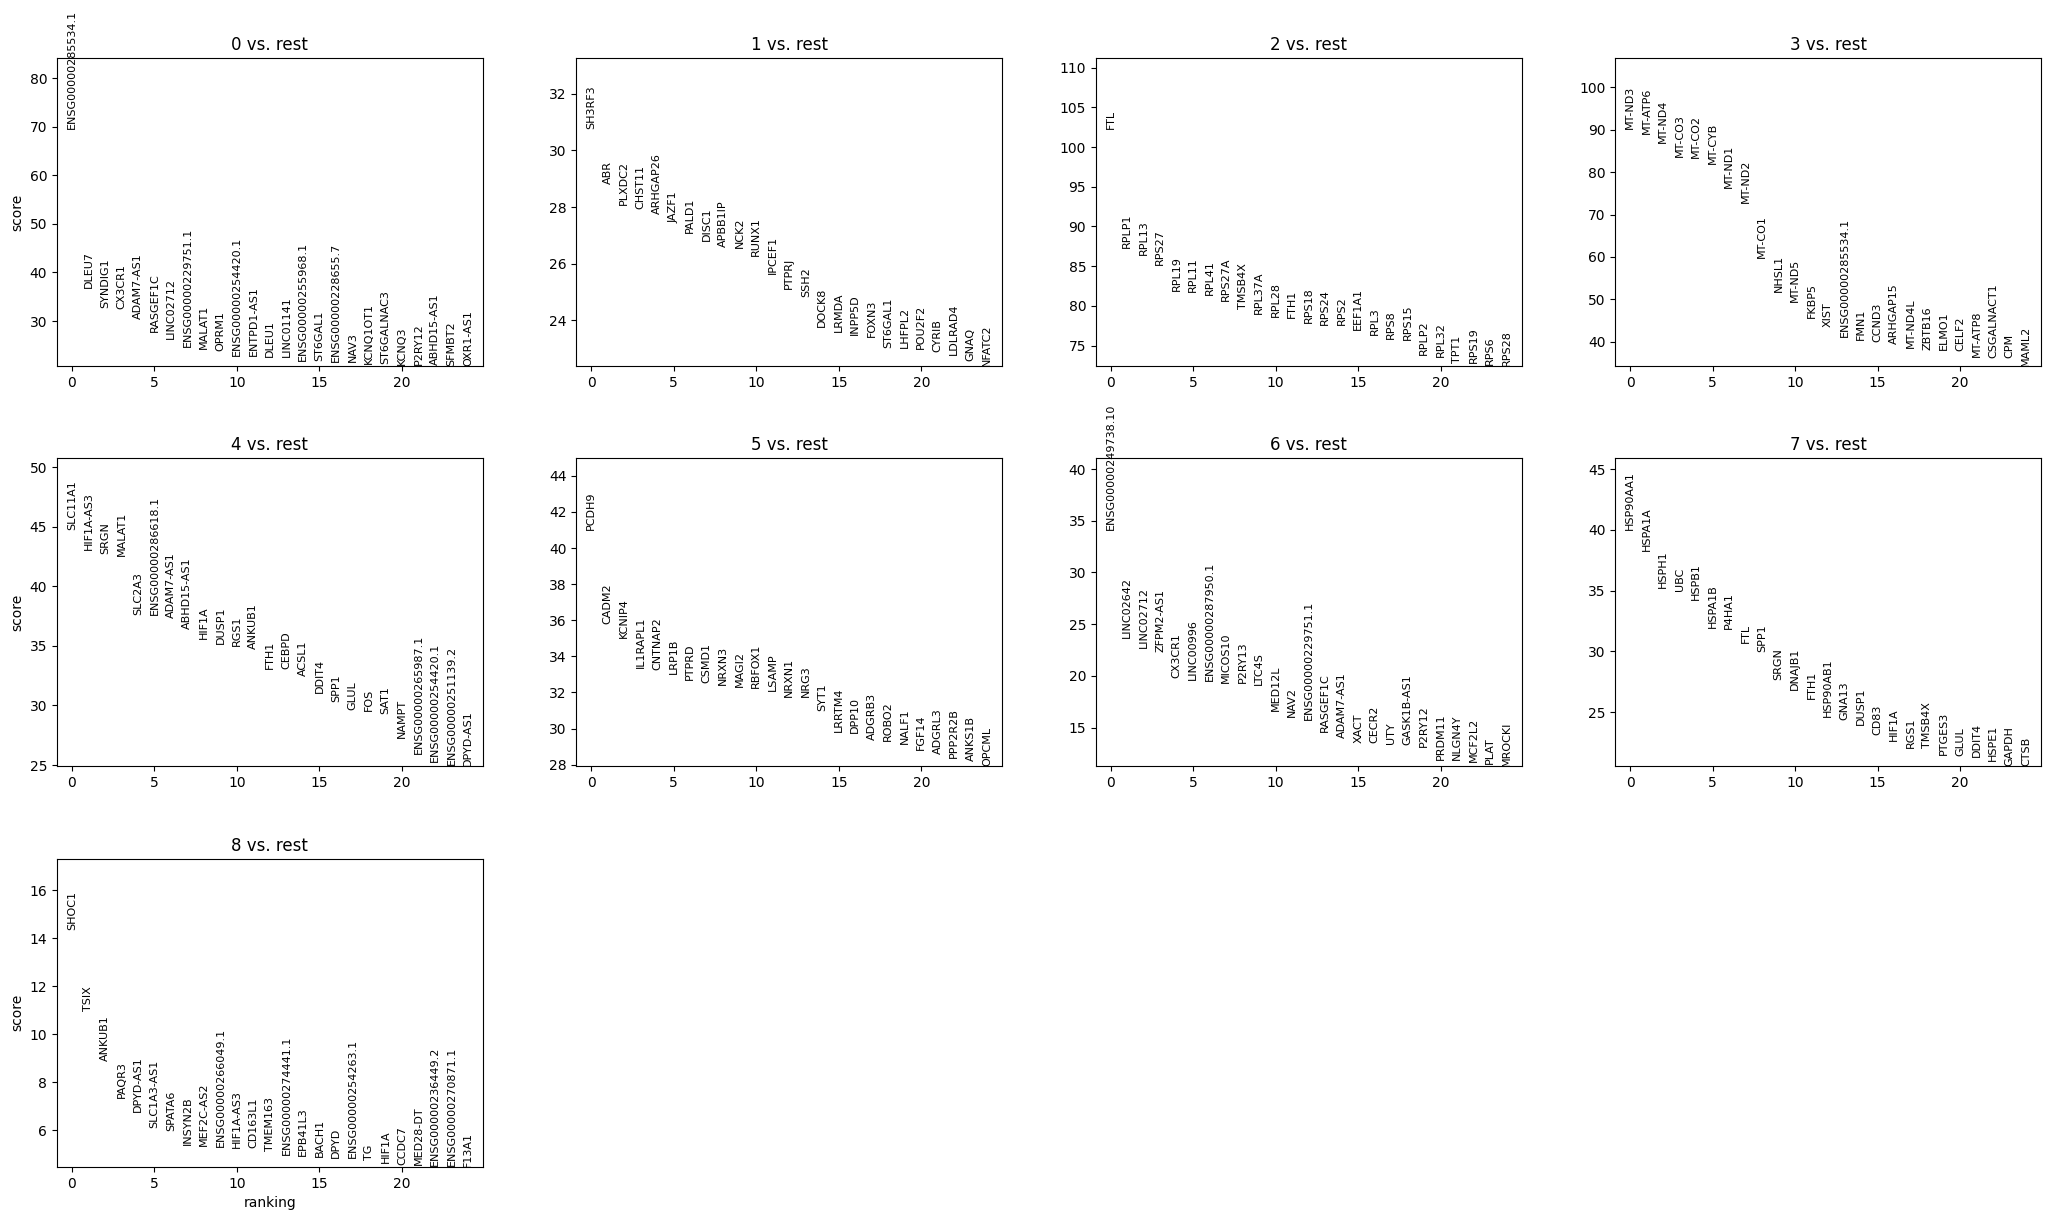

In [26]:
print(f'    Start to identify marker gene {studyID}')
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False,save=f'{studyID}_clustermarker_res{res}_within_microglia.pdf')
cluster_marker = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
cluster_marker.to_csv(f'{output_dir}/{studyID}_clustermarker_within_microglia.csv')